In [420]:
from dbhelper import MyDB, PgDB, get_oneday, get_oneweek, get_dow_average
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np

In [227]:
def single_plot(df):
    fig = plt.figure(figsize=(14,6))
    plt.plot(df.date, df.waittime, alpha=.4)
    plt.plot(df.date, df.volume, alpha=.4)
    plt.show()

In [115]:
def compare_ns(start, location, lane):
    fig = plt.figure(figsize=(14,4))
    for i, direction in enumerate(['Northbound', 'Southbound']):
        df = oneday(start, location, direction, lane)
        plt.subplot(1, 2, i + 1)
        plt.title(direction)
        plt.plot(df.date, df.waittime)
        plt.plot(df.date, df.volume)
    plt.show()

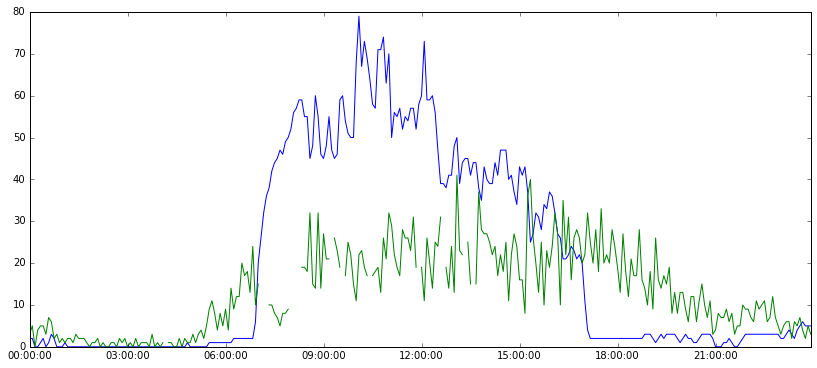

In [111]:
lane = 'Car'
location = 'Pacific Highway'
direction = 'Southbound'
start = datetime.datetime(2010, 10, 2)

df = get_oneday(start, location, direction, lane)
df.head()
single_plot(df)

## Compare north/south on same day

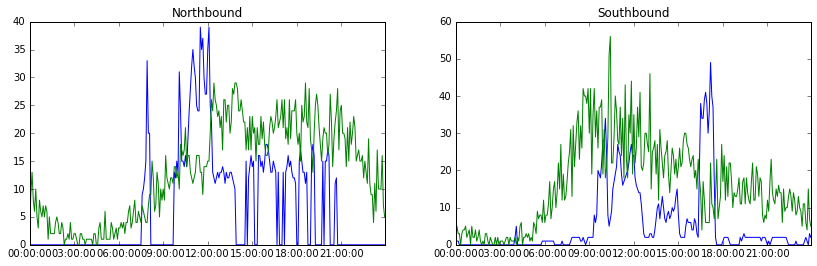

In [131]:
lane = 'Car'
location = 'Peace Arch'
start = datetime.datetime(2015, 10, 3)
compare_ns(start, location, lane)

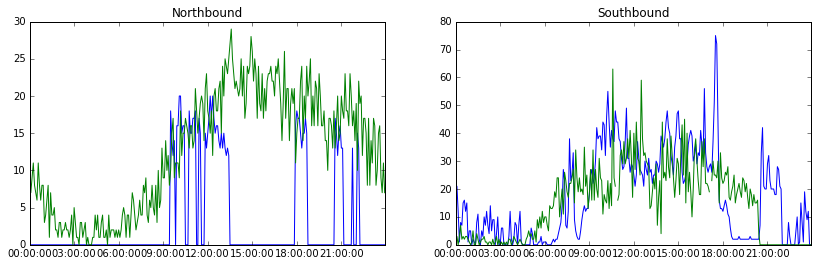

In [135]:
start = datetime.datetime(2015, 11, 28)
compare_ns(start, location, lane)

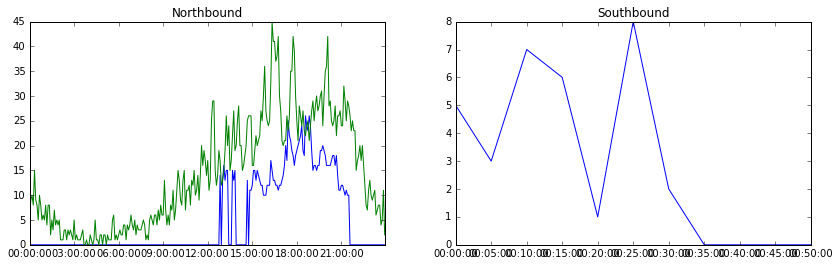

In [136]:
start = datetime.datetime(2015, 11, 29)
compare_ns(start, location, lane)

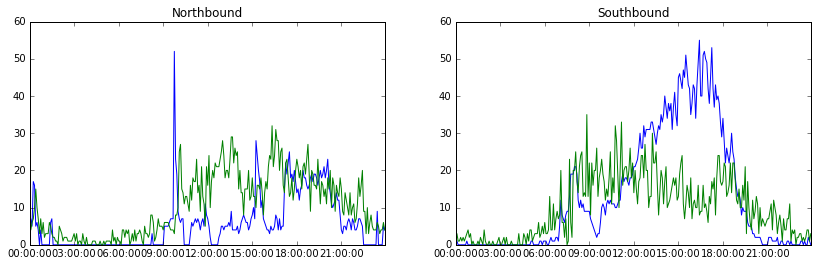

In [137]:
lane = 'Car'
location = 'Pacific Highway'
start = datetime.datetime(2015, 11, 29)
compare_ns(start, location, lane)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 287
Data columns (total 7 columns):
date              288 non-null datetime64[ns]
location_name     288 non-null object
direction_name    288 non-null object
lane_name         288 non-null object
waittime          286 non-null float64
volume            278 non-null float64
valid             288 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 18.0+ KB


## Data issues

1. "None"
2. NaN - Is this the same number missing as raw data and in Mongo?
3. Missing data
    * spotty wait time data, e.g. Peace Arch
    
Need a report on zeros, nulls for each day

### Distribution of wait time zeros/nulls 

In [159]:
query = '''
        select 
            DATE_FORMAT(date, '%Y-%m-%d') as day,
            count(waittime) as wt_total,
            sum(case when waittime = 0 then 1 else 0 end) as wt_zero,
            sum(case when waittime is null then 1 else 0 end) as wt_null,
            sum(1-valid) as invalid
        from crossingdata_denorm
        where
            location_name = 'Peace Arch'
            and lane_name = 'Car'
            and direction_name = 'Southbound'
            #and date >= '2015-01-01'
        group by DATE_FORMAT(date, '%Y-%m-%d')
        '''

with MyDB() as db:
    df = pd.read_sql(query, con=db.conn)
    
df.head()

,day,wt_total,wt_zero,wt_null,invalid
0,2007-01-01,288,93,0,0
1,2007-01-02,288,99,0,0
2,2007-01-03,288,103,0,0
3,2007-01-04,288,108,0,0
4,2007-01-05,288,103,0,0


In [164]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
wt_total,3256,254.714988,85.507268,0,285,288,288,288
wt_zero,3256,89.792998,50.964909,0,62,86,117,285
wt_null,3256,33.285012,85.507268,0,0,0,3,288
invalid,3256,20.009828,65.089167,0,0,0,2,288


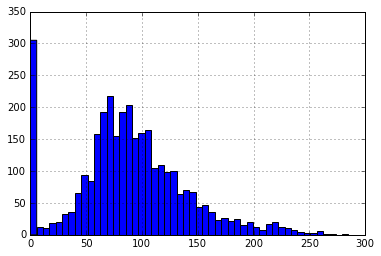

In [161]:
df.wt_zero.hist(bins=50);

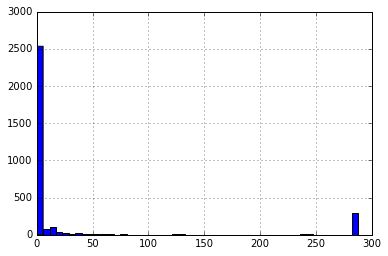

In [162]:
df.wt_null.hist(bins=50);

In [165]:
query = '''
        select 
            DATE_FORMAT(date, '%Y-%m-%d') as day,
            count(waittime) as wt_total,
            sum(case when waittime = 0 then 1 else 0 end) as wt_zero,
            sum(case when waittime is null then 1 else 0 end) as wt_null,
            sum(1-valid) as invalid
        from crossingdata_denorm
        where
            location_name = 'Peace Arch'
            and lane_name = 'Car'
            and direction_name = 'Northbound'
            #and date >= '2015-01-01'
        group by DATE_FORMAT(date, '%Y-%m-%d')
        '''

with MyDB() as db:
    df = pd.read_sql(query, con=db.conn)
    
df.describe().T

,count,mean,std,min,25%,50%,75%,max
wt_total,3256,248.698096,92.992344,0,287,288,288.00,288
wt_zero,3256,166.131450,82.208098,0,121,173,231.00,288
wt_null,3256,39.301904,92.992344,0,0,0,1.00,288
invalid,3256,37.155098,91.569430,0,0,0,0.25,288


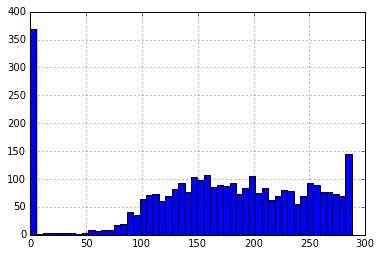

In [166]:
df.wt_zero.hist(bins=50);

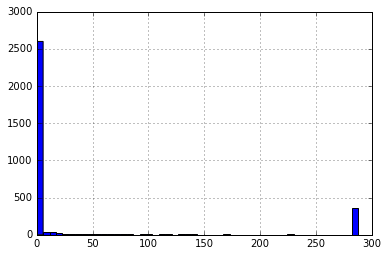

In [167]:
df.wt_null.hist(bins=50);

In [170]:
df[df.wt_zero == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
wt_total,364,0.695055,7.961538,0,0,0,0,120
wt_zero,364,0.000000,0.000000,0,0,0,0,0
wt_null,364,287.304945,7.961538,168,288,288,288,288
invalid,364,277.810440,51.977955,0,288,288,288,288


### Wait time data inconsistency
* Distribution of zero data is very different between N/S directions at Peace Arch
* About HALF of northbound data has zero for waittimes
* Spike at 0 zeroes corresponds to data missing for entire day

#### May be possible to define a heuristic to determine when data is valid

### Compare to volume
* Much less missing data
* Most of 0 zeros are due to invalid data, but unlike wait time data, the distribution of zero's skews towards the left.
* I.e., there are a few cases of zeros, but this may actually correspond to real data

In [174]:
query = '''
        select 
            DATE_FORMAT(date, '%Y-%m-%d') as day,
            count(volume) as vol_total,
            sum(case when volume = 0 then 1 else 0 end) as vol_zero,
            sum(case when volume is null then 1 else 0 end) as vol_null,
            sum(1-valid) as invalid
        from crossingdata_denorm
        where
            location_name = 'Peace Arch'
            and lane_name = 'Car'
            and direction_name = 'Northbound'
            #and date >= '2015-01-01'
        group by DATE_FORMAT(date, '%Y-%m-%d')
        '''

with MyDB() as db:
    df = pd.read_sql(query, con=db.conn)
    
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vol_total,3256,250.106265,91.875544,0,287,288,288.00,288
vol_zero,3256,12.929361,27.028038,0,4,9,14.00,288
vol_null,3256,37.893735,91.875544,0,0,0,1.00,288
invalid,3256,37.155098,91.569430,0,0,0,0.25,288


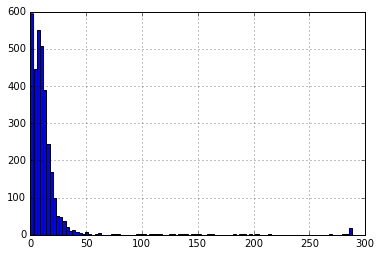

In [177]:
df.vol_zero.hist(bins=100);

In [176]:
df[df.vol_zero == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
vol_total,446,40.091928,85.255034,0,0,0,0,288
vol_zero,446,0.000000,0.000000,0,0,0,0,0
vol_null,446,247.908072,85.255034,0,288,288,288,288
invalid,446,244.834081,90.325227,0,288,288,288,288


In [178]:
query = '''
        select 
            DATE_FORMAT(date, '%Y-%m-%d') as day,
            count(volume) as vol_total,
            sum(case when volume = 0 then 1 else 0 end) as vol_zero,
            sum(case when volume is null then 1 else 0 end) as vol_null,
            sum(1-valid) as invalid
        from crossingdata_denorm
        where
            location_name = 'Peace Arch'
            and lane_name = 'Car'
            and direction_name = 'Southbound'
            #and date >= '2015-01-01'
        group by DATE_FORMAT(date, '%Y-%m-%d')
        '''

with MyDB() as db:
    df = pd.read_sql(query, con=db.conn)
    
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vol_total,3256,255.096744,76.987881,0,271,285,287,288
vol_zero,3256,16.129914,10.856189,0,10,15,21,113
vol_null,3256,32.903256,76.987881,0,1,3,17,288
invalid,3256,20.009828,65.089167,0,0,0,2,288


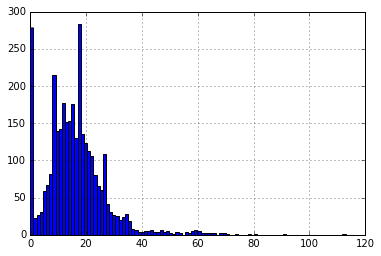

In [179]:
df.vol_zero.hist(bins=100);

In [180]:
df[df.vol_zero == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
vol_total,255,14.603922,53.110233,0,0.0,0,0,287
vol_zero,255,0.000000,0.000000,0,0.0,0,0,0
vol_null,255,273.396078,53.110233,1,288.0,288,288,288
invalid,255,196.937255,127.694379,0,20.5,288,288,288


### Does the data show patterns of consistency over time?

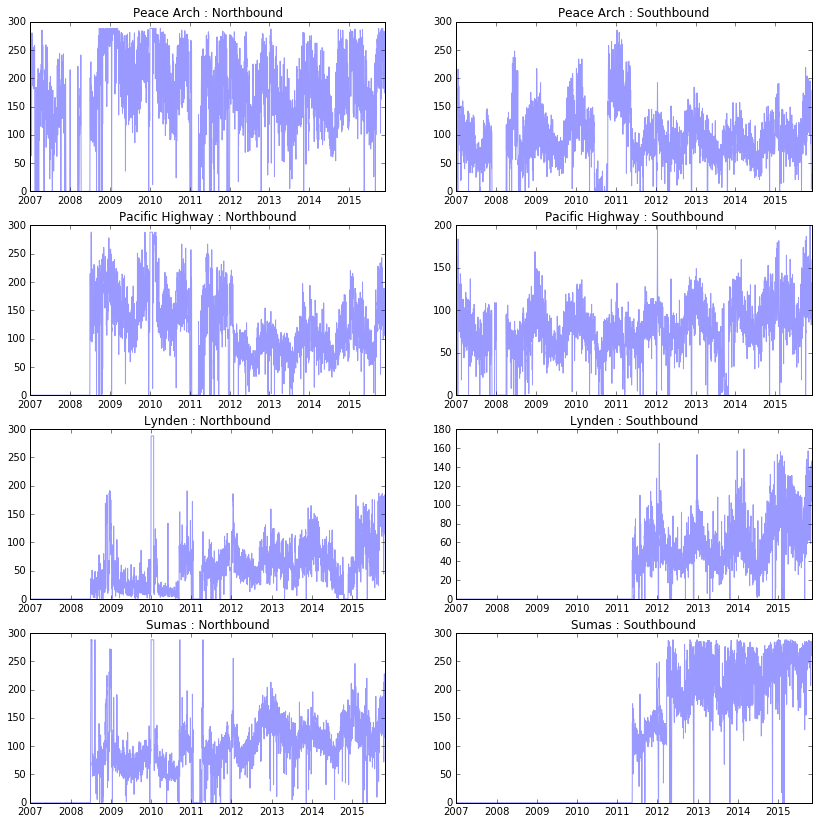

In [203]:
query = '''
        select 
            DATE_FORMAT(date, '%Y-%m-%d') as day,
            count(waittime) as wt_total,
            sum(case when waittime = 0 then 1 else 0 end) as wt_zero,
            sum(case when waittime is null then 1 else 0 end) as wt_null,
            sum(1-valid) as invalid
        from crossingdata_denorm
        where
            location_name = '{0}'
            and lane_name = 'Car'
            and direction_name = '{1}'
        group by DATE_FORMAT(date, '%Y-%m-%d')
        '''

plt.figure(figsize=(14,14))
with MyDB() as db:
    i = 1
    for location in ['Peace Arch', 'Pacific Highway', 'Lynden', 'Sumas']:
        for direction in ['Northbound', 'Southbound']:
            df = pd.read_sql(query.format(location, direction), con=db.conn)
            df.day = pd.to_datetime(df.day)
            
            plt.subplot(4, 2, i)
            plt.title("{0} : {1}".format(location, direction))
            plt.plot(df.day, df.wt_zero, alpha=.4)
            
            i += 1
            
plt.show();

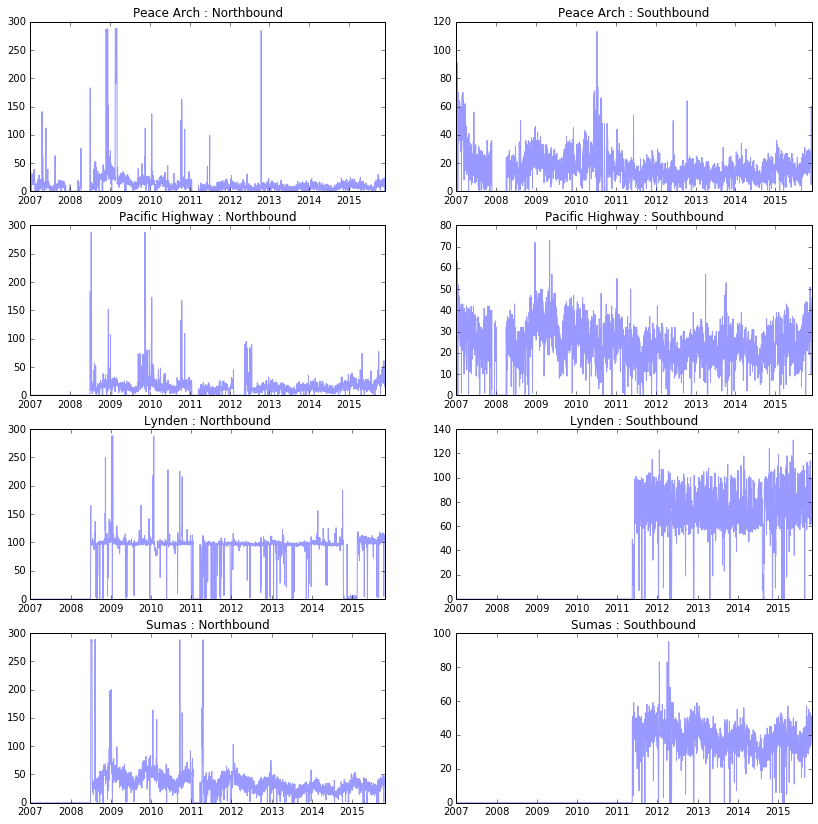

In [204]:
query = '''
        select 
            DATE_FORMAT(date, '%Y-%m-%d') as day,
            count(volume) as vol_total,
            sum(case when volume = 0 then 1 else 0 end) as vol_zero,
            sum(case when volume is null then 1 else 0 end) as vol_null,
            sum(1-valid) as invalid
        from crossingdata_denorm
        where
            location_name = '{0}'
            and lane_name = 'Car'
            and direction_name = '{1}'
        group by DATE_FORMAT(date, '%Y-%m-%d')
        '''

plt.figure(figsize=(14,14))
with MyDB() as db:
    i = 1
    for location in ['Peace Arch', 'Pacific Highway', 'Lynden', 'Sumas']:
        for direction in ['Northbound', 'Southbound']:
            df = pd.read_sql(query.format(location, direction), con=db.conn)
            df.day = pd.to_datetime(df.day)
            
            plt.subplot(4, 2, i)
            plt.title("{0} : {1}".format(location, direction))
            plt.plot(df.day, df.vol_zero, alpha=.4)
            
            i += 1
            
plt.show();

## Compare wait times across Thanksgiving weeks
Maybe zeros are real

In [292]:
import holidays

turkeydays = sorted([date for date, name in holidays.US(years=range(2007, 2016)).items() if name == 'Thanksgiving'])
turkeydays

[datetime.date(2007, 11, 22),
 datetime.date(2008, 11, 27),
 datetime.date(2009, 11, 26),
 datetime.date(2010, 11, 25),
 datetime.date(2011, 11, 24),
 datetime.date(2012, 11, 22),
 datetime.date(2013, 11, 28),
 datetime.date(2014, 11, 27),
 datetime.date(2015, 11, 26)]

In [315]:
print datetime.date(2013, 11, 28)
print start[6]

2013-11-28
2013-11-25


#### Strange bug where MySQL hangs when getting data from 11/25 for 7 days, but any other interval seems fine
Migrating to postgres

In [341]:
df = get_oneweek(start[6], location, direction, lane)
df.head()

,date,location_name,direction_name,lane_name,waittime,volume,valid
0,2013-11-25 00:00:00,Pacific Highway,Southbound,Car,0,1,1
1,2013-11-25 00:05:00,Pacific Highway,Southbound,Car,0,3,1
2,2013-11-25 00:10:00,Pacific Highway,Southbound,Car,0,1,1
3,2013-11-25 00:15:00,Pacific Highway,Southbound,Car,0,0,1
4,2013-11-25 00:20:00,Pacific Highway,Southbound,Car,0,1,1


### Daily wait times averaged over month

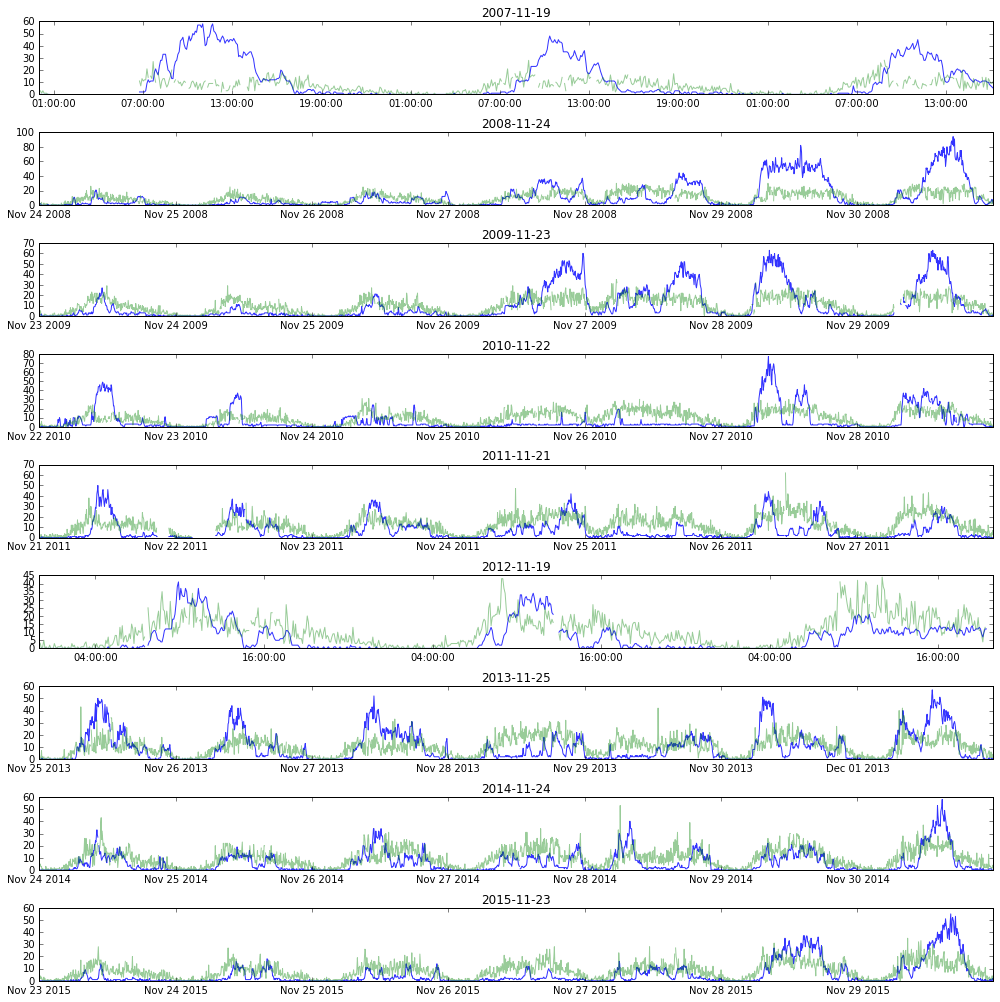

In [344]:
lane = 'Car'
location = 'Pacific Highway'
direction = 'Southbound'
start = [dt - datetime.timedelta(days=3) for dt in turkeydays]
fig = plt.figure(figsize=(14,14))

for i, dt in enumerate(start):
    df = get_oneweek(dt, location, direction, lane)
    plt.subplot(len(start), 1, i + 1)
    plt.title(str(dt))
    plt.plot(df.date, df.waittime, alpha=.8)
    plt.plot(df.date, df.volume, alpha=.4)

plt.tight_layout()
plt.show()

In [353]:
df.head()

,date,location_name,direction_name,lane_name,waittime,volume,valid
0,2007-11-19 00:00:00,Pacific Highway,Northbound,Car,None,None,0
1,2007-11-19 00:05:00,Pacific Highway,Northbound,Car,None,None,0
2,2007-11-19 00:10:00,Pacific Highway,Northbound,Car,None,None,0
3,2007-11-19 00:15:00,Pacific Highway,Northbound,Car,None,None,0
4,2007-11-19 00:20:00,Pacific Highway,Northbound,Car,None,None,0


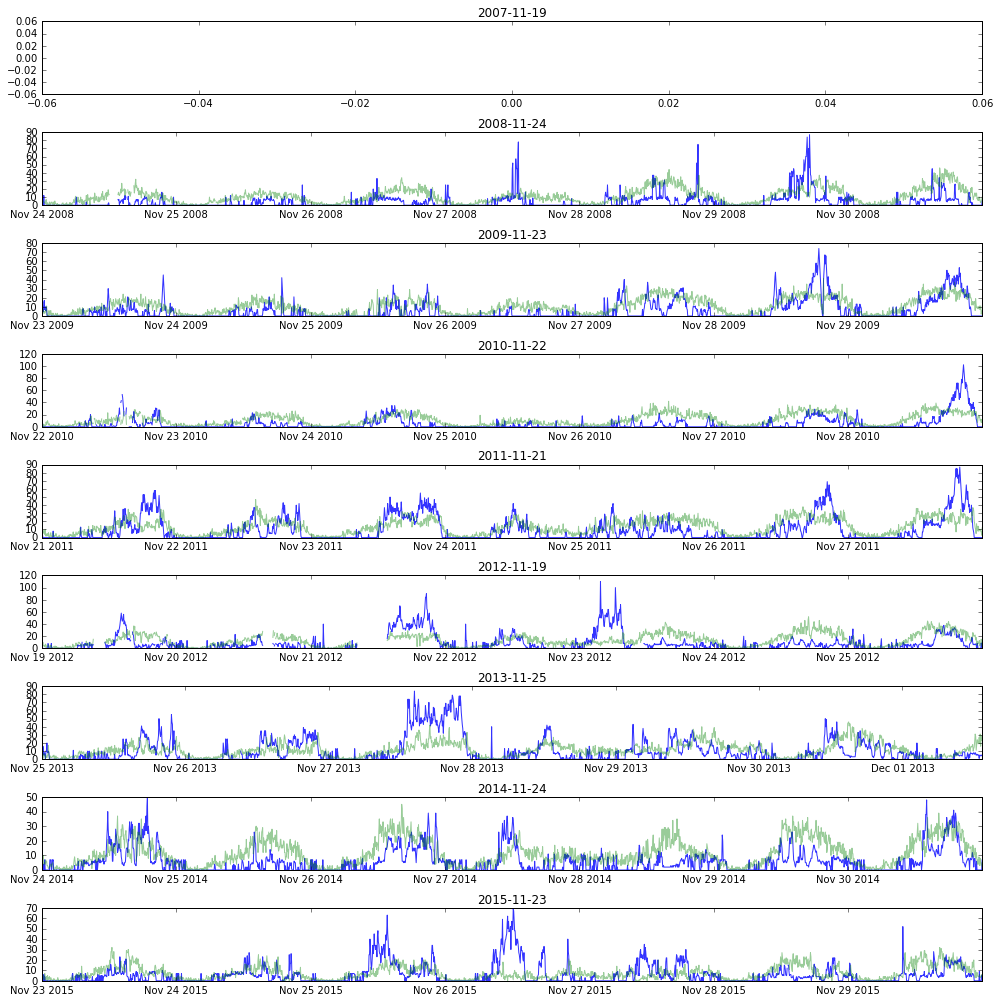

In [355]:
lane = 'Car'
location = 'Pacific Highway'
direction = 'Northbound'
start = [dt - datetime.timedelta(days=3) for dt in turkeydays]
fig = plt.figure(figsize=(14,14))

for i, dt in enumerate(start):
    df = get_oneweek(dt, location, direction, lane)
    plt.subplot(len(start), 1, i + 1)
    plt.title(str(dt))
    if df.valid.sum() > 0:
        plt.plot(df.date, df.waittime, alpha=.8)
        plt.plot(df.date, df.volume, alpha=.4)
    else:
        plt.plot()

plt.tight_layout()
plt.show()

### 6 months from Thanksgiving
* Delays are smaller
* Spikes are smaller
* For holiday and non-holiday, there appears to be both year to year and day to day correlation

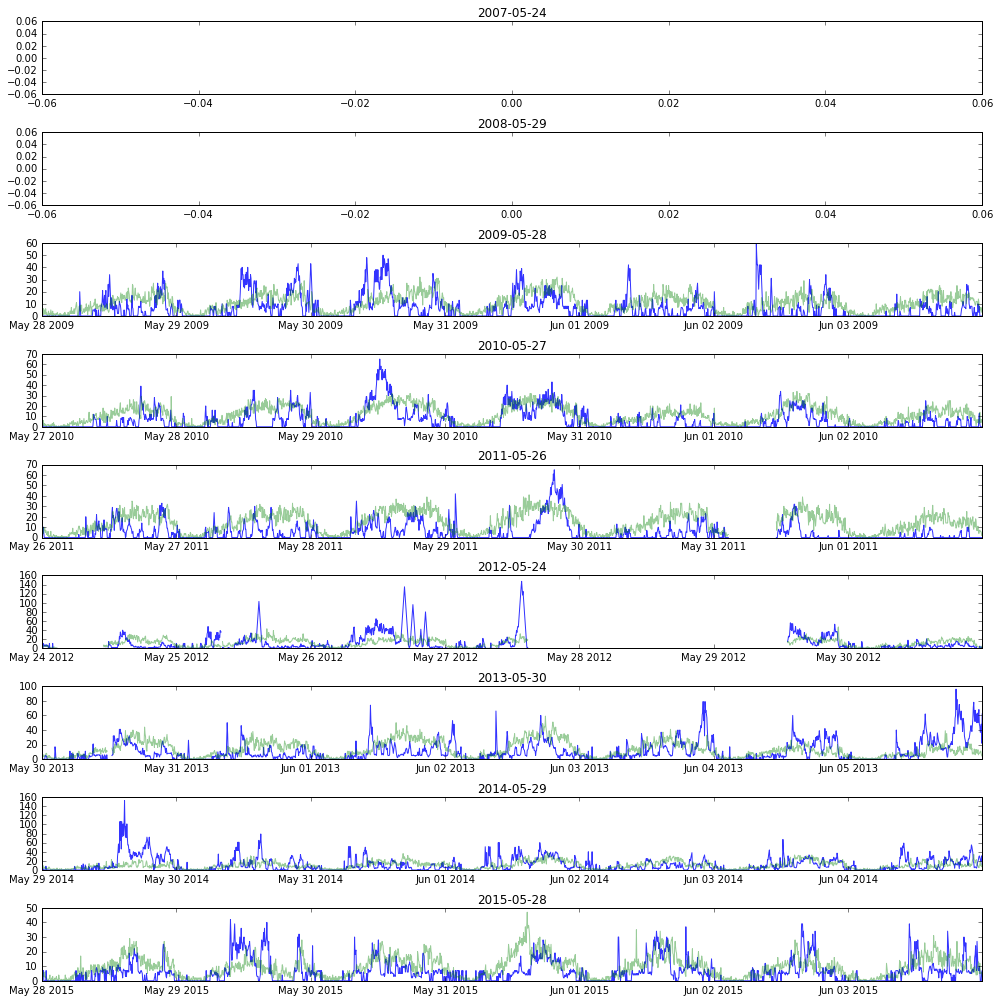

In [356]:
lane = 'Car'
location = 'Pacific Highway'
direction = 'Northbound'
start = [dt - datetime.timedelta(weeks=26) for dt in turkeydays]
fig = plt.figure(figsize=(14,14))

for i, dt in enumerate(start):
    df = get_oneweek(dt, location, direction, lane)
    plt.subplot(len(start), 1, i + 1)
    plt.title(str(dt))
    if df.valid.sum() > 0:
        plt.plot(df.date, df.waittime, alpha=.8)
        plt.plot(df.date, df.volume, alpha=.4)
    else:
        plt.plot()

plt.tight_layout()
plt.show()

### What does a day of week average look like?

In [388]:
lane = 'Car'
location = 'Peace Arch'
direction = 'Southbound'
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2016, 1, 1)

df = get_dow_average(start, end, location, direction, lane)

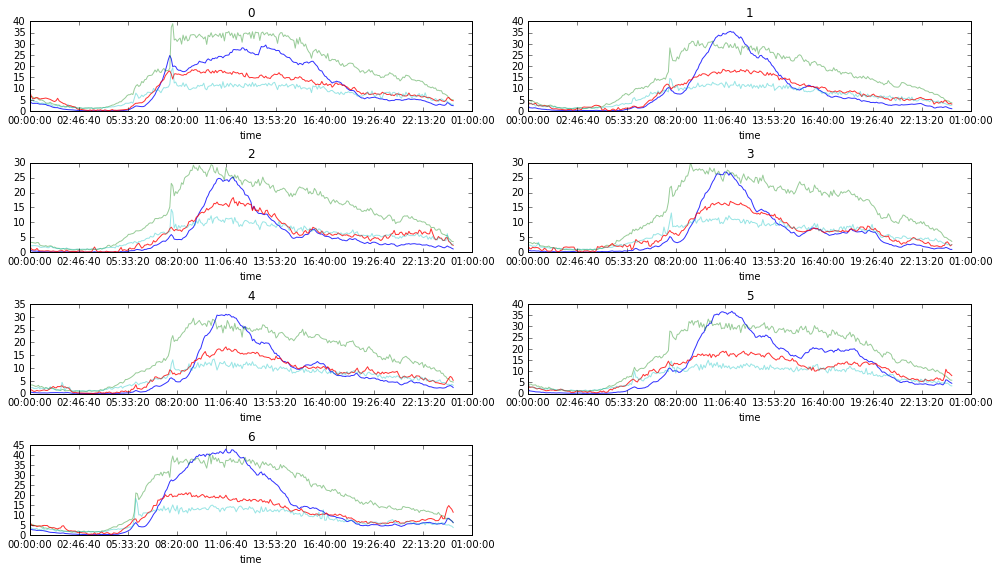

In [390]:
fig = plt.figure(figsize=(14,8))

for i in range(7):
    dfday = df[df.dow == i]
    plt.subplot(4, 2, i + 1)
    plt.title(str(i))
    if df.sum_valid.sum() > 0:
        plt.plot(dfday.time, dfday.avg_wt, alpha=.8)
        plt.plot(dfday.time, dfday.avg_vol, alpha=.4)
        plt.plot(dfday.time, dfday.std_wt, alpha=.8)
        plt.plot(dfday.time, dfday.std_vol, alpha=.4)
    else:
        plt.plot()

plt.tight_layout()
plt.show()

In [410]:
lane = 'Car'
location = 'Peace Arch'
direction = 'Southbound'
start = datetime.datetime(2014, 12, 1)
end = datetime.datetime(2015, 12, 1)

df = get_dow_average(start, end, location, direction, lane)

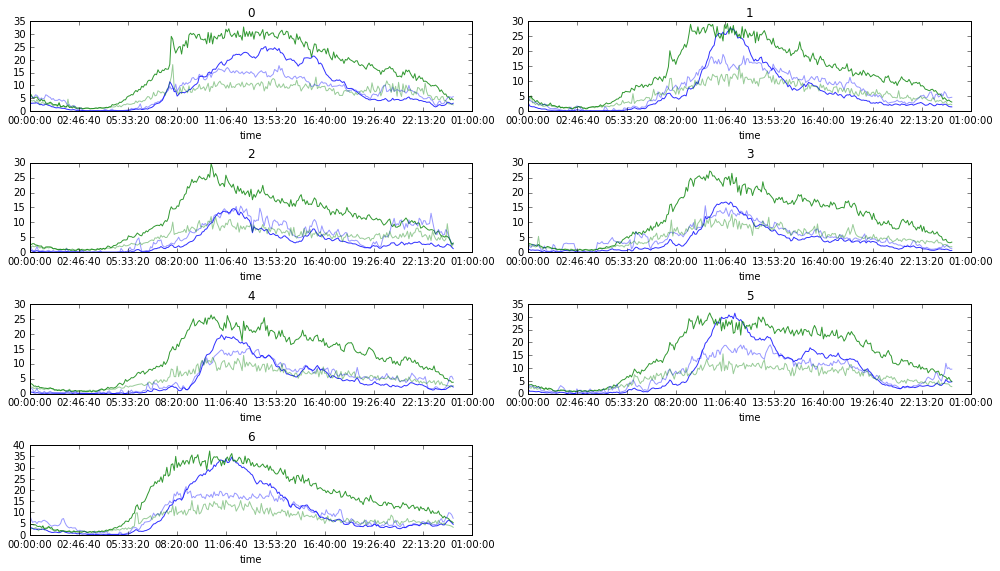

In [411]:
fig = plt.figure(figsize=(14,8))

for i in range(7):
    dfday = df[df.dow == i]
    plt.subplot(4, 2, i + 1)
    plt.title(str(i))
    if df.sum_valid.sum() > 0:
        plt.plot(dfday.time, dfday.avg_wt, color='b', alpha=.8)
        plt.plot(dfday.time, dfday.avg_vol, color='g', alpha=.8)
        plt.plot(dfday.time, dfday.std_wt, color='b', alpha=.4)
        plt.plot(dfday.time, dfday.std_vol, color='g', alpha=.4)
    else:
        plt.plot()

plt.tight_layout()
plt.show()

### 1 year average resembles:
http://traffic.calit2.net/border/border-wait-times.php?type=passenger&sub=standard&port=300402

### High variability reinforces hypothesis that a better prediction can be made

## What does a single day average look?
E.g. New Years Day

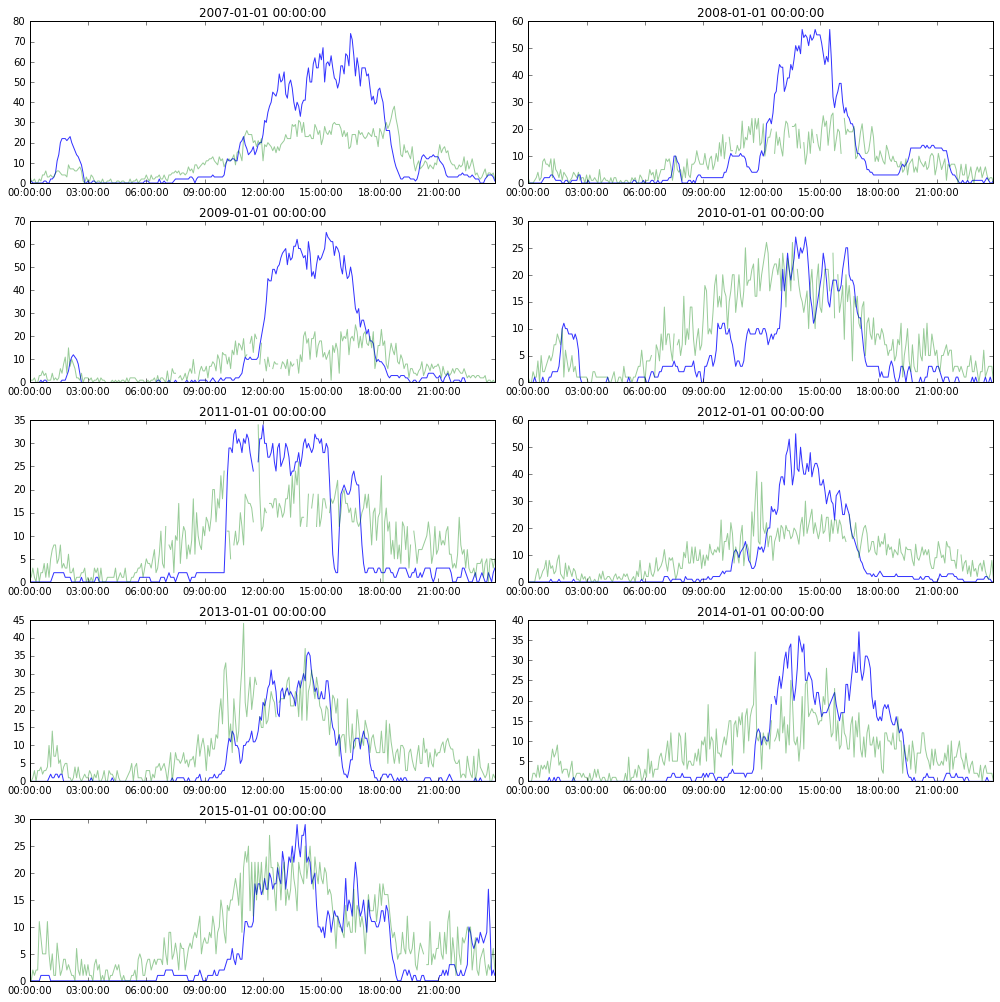

In [413]:
lane = 'Car'
location = 'Pacific Highway'
direction = 'Southbound'
start = [datetime.datetime(year, 1, 1) for year in range(2007, 2016)]
fig = plt.figure(figsize=(14,14))

for i, dt in enumerate(start):
    df = get_oneday(dt, location, direction, lane)
    plt.subplot(5, 2, i + 1)
    plt.title(str(dt))
    if df.valid.sum() > 0:
        plt.plot(df.date, df.waittime, alpha=.8)
        plt.plot(df.date, df.volume, alpha=.4)
    else:
        plt.plot()

plt.tight_layout()
plt.show()

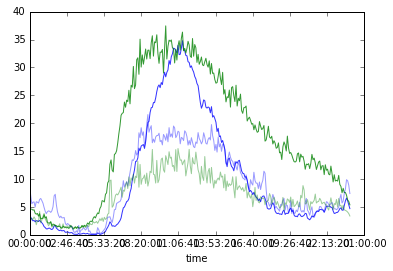

In [419]:
lane = 'Car'
location = 'Pacific Highway'
direction = 'Southbound'

query = '''
        select
            date::time as time,
            avg(waittime) as avg_wt,
            avg(volume) as avg_vol,
            stddev_samp(waittime) as std_wt,
            stddev_samp(volume) as std_vol,
            sum(valid) as sum_valid
        from crossingdata_denorm
        where extract(MONTH from date) = 1
            and extract(DAY from date) = 1
            and location_name = '%s'
            and direction_name = '%s'
            and lane_name = '%s'
            and valid = 1
        group by date::time
        '''

with PgDB() as db:
    df = pd.read_sql(query % (location,
                              direction,
                              lane), con=db.conn)

plt.plot(dfday.time, dfday.avg_wt, color='b', alpha=.8)
plt.plot(dfday.time, dfday.avg_vol, color='g', alpha=.8)
plt.plot(dfday.time, dfday.std_wt, color='b', alpha=.4)
plt.plot(dfday.time, dfday.std_vol, color='g', alpha=.4);

### Even for a single holiday, variability is high

### What about year to year covariance?
Look at Thanksgiving week

In [448]:
lane = 'Car'
location = 'Pacific Highway'
direction = 'Southbound'
start = [dt - datetime.timedelta(days=3) for dt in turkeydays]
fig = plt.figure(figsize=(14,14))

yearly = []

for dt in start:
    df = get_oneweek(dt, location, direction, lane)
    
    yearly.append(np.array(df.fillna(0).waittime))

In [438]:
corr = pd.DataFrame(np.corrcoef(yearly))
corr

,0,1,2,3,4,5,6,7,8
0,1.000000,-0.125011,-0.071640,0.328543,0.559330,0.865163,0.526215,0.280997,-0.044711
1,-0.125011,1.000000,0.675212,0.428739,0.355362,-0.125104,0.458178,0.541463,0.829132
2,-0.071640,0.675212,1.000000,0.459074,0.463858,-0.093886,0.480662,0.495753,0.487583
3,0.328543,0.428739,0.459074,1.000000,0.546756,0.310142,0.641850,0.381150,0.387699
4,0.559330,0.355362,0.463858,0.546756,1.000000,0.556003,0.710463,0.535350,0.312619
5,0.865163,-0.125104,-0.093886,0.310142,0.556003,1.000000,0.518341,0.261595,-0.029794
6,0.526215,0.458178,0.480662,0.641850,0.710463,0.518341,1.000000,0.618174,0.448611
7,0.280997,0.541463,0.495753,0.381150,0.535350,0.261595,0.618174,1.000000,0.547641
8,-0.044711,0.829132,0.487583,0.387699,0.312619,-0.029794,0.448611,0.547641,1.000000


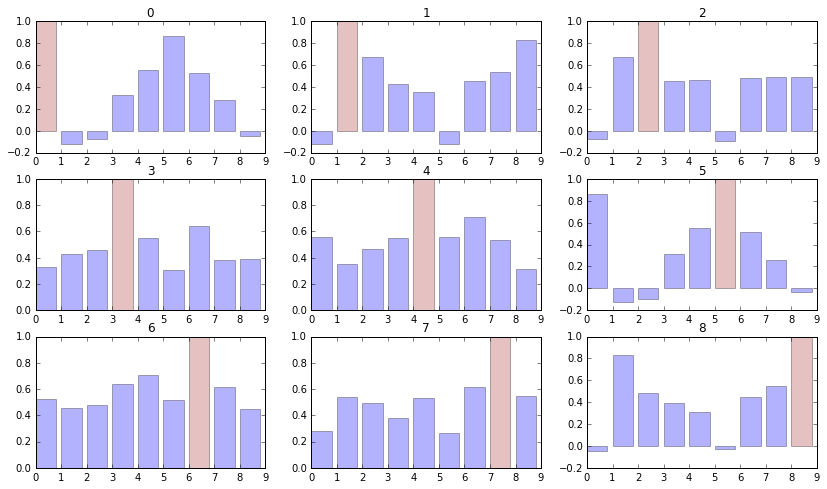

In [447]:
fig = plt.figure(figsize=(14,8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title(i)
    ax = plt.bar(range(9), corr[i], alpha=0.3)
    ax.patches[i].set_facecolor('#aa3333')
plt.show()

There appears to be some correlation with previous years, although correlation fades after 2 years.  Even at 2 years, the correlation tends to be weak, and often weaker than a randomly selected year.

## Still need to address data quality where wait time falls to zero between spikes and during periods of high volume

Example:
http://www.cascadegatewaydata.com/CrossingLane/5/2015/9/1?data=sum-vol%2Cavg-delay&format=Chart

In [449]:
lane = 'Car'
location = 'Peace Arch'
direction = 'Northbound'
dt = datetime.datetime(2015, 9, 1)

df = get_oneday(dt, location, direction, lane)

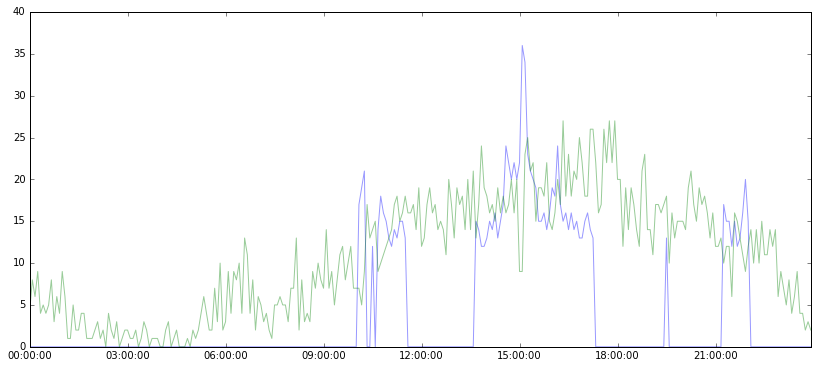

In [450]:
single_plot(df)

In [453]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
waittime,288,4.017361,7.431666,0,0,0,0.00,36
volume,288,10.760417,7.077094,0,4,11,16.25,27
valid,288,1.000000,0.000000,1,1,1,1.00,1


#### According to border data manager, northbound data has an issue where low wait times cannot be measured and are reported as zero